In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from collections import Counter
import re
from part_of_speech import get_part_of_speech
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
import numpy as np
from supervenn import supervenn
from wordcloud import WordCloud


In [2]:
df = pd.read_csv('../okcupiddata/profiles.csv')
#make dataframe just containing essays
df_essays = df[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9']]
df_essays['corpus'] = df_essays[df_essays.columns[0:]].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1)
corpus = df_essays['corpus'].tolist()

def remove_noise(text):
    #remove html tags
    clean = re.compile('<.*?>')
    text = re.sub(clean, '', text)
    text = re.sub('href', '', text)
    text = re.sub('classilink', '', text)
    text = re.sub('ilink', '', text)
    #remove punctuation
    text = re.sub(r'[^\w\s]+','',text)
    #remove newline, tab
    text = re.sub("(\\d|\\W)+"," ",text)
    return text

def lemmatize(text):
    stop_words = set(stopwords.words("english"))
    tokenized = word_tokenize(str(text))
    #print(len(tokenized))
    lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized if not token in stop_words and len(token) >2]
    
    cleaned = " ".join(lemmatized)
    return cleaned

lemmatizer = WordNetLemmatizer()

denoised = [remove_noise(str(i)) for i in corpus]
normalized = [lemmatize(i) for i in denoised]


<ipython-input-2-8c568cd1d240>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_essays['corpus'] = df_essays[df_essays.columns[0:]].apply(


In [3]:
print(normalized[0])

would love think kind intellectual either dumbest smart guy smart dumb guy cant say tell difference love talk idea concept forge odd metaphor instead recite cliche like simularities friend mine house underwater salt mine favorite word salt way weird choice know thing life well metaphor seek make little well everyday productively lazy way get tire tie shoe consider hire five year old would probably tie shoe decide wear leather shoe dress shoe love really serious really deep conversation really silly stuff will snap light hearted rant kiss dont funny able make laugh able bend spoon mind telepathically make smile still work love life cool let wind blow extra point read guess favorite video game hint give yet lastly good attention span currently work international agent freight forwarding company import export domestic know work online class try well free time perhaps hour worth good book video game lazy sunday make people laugh ranting good salt find simplicity complexity complexity simpl

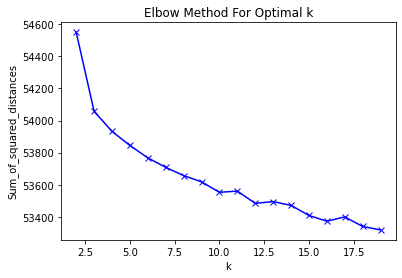

In [4]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf = vectorizer.fit_transform(normalized)
words = vectorizer.get_feature_names()

Sum_of_squared_distances = []
K = range(2,20)

for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(tfidf)
   Sum_of_squared_distances.append(km.inertia_)
   
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
#10 could work, or 12

In [5]:
true_k = 10
#set up clustering
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=true_k)
#fit the data
model.fit(tfidf)

#this loop transforms the numbers back into words
common_words = model.cluster_centers_.argsort()[:,-1:-16:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : like, thing, really, love, good, dont, people, think, time, make, friend, lot, know, work, movie
1 : music, like, love, food, movie, book, friend, work, good, make, time, thing, people, new, life
2 : like, thing, dont, people, make, think, know, time, good, love, really, want, work, life, say
3 : love, friend, good, like, music, life, movie, people, food, family, laugh, work, time, make, enjoy
4 : friend, work, like, family, good, fun, love, time, movie, lol, guy, food, life, music, sport
5 : class, like, love, thing, people, good, time, music, make, think, friend, dont, work, really, ive
6 : new, friend, love, enjoy, travel, like, work, good, try, time, food, thing, city, family, live
7 : life, love, enjoy, good, like, friend, time, people, look, thing, live, make, work, music, share
8 : amp, love, like, friend, music, good, life, work, time, make, food, family, thing, enjoy, movie
9 : like, work, love, look, want, friend, life, good, ask, make, know, time, music, thing, live


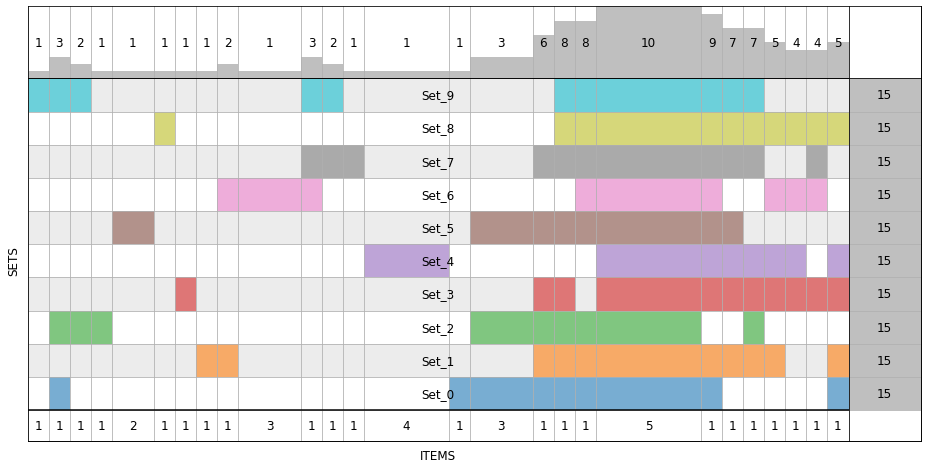

In [15]:
word_list = []
for centroid in common_words:
    word_list.append(set(words[word] for word in centroid))

plt.figure(figsize=(16, 8))
supervenn(word_list)

Cluster: 0


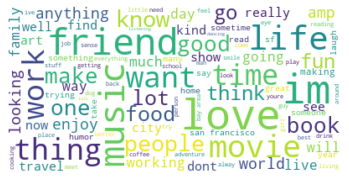

Cluster: 1


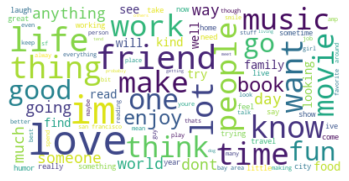

Cluster: 2


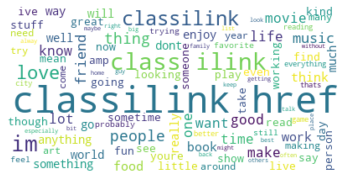

In [11]:
result={'cluster':labels,'profile':denoised}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['profile'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   #print('Titles')
   #titles=profile_cl[profile_cl.cluster==k]['title']         
   #print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()